[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)<br>
Adapted by Claudio Sartori

# Classification with Decision Tree - hyperparameter tuning (__model selection__) with Grid Search and Cross Validation

We use here the Decision Tree and the standard `CrossValidation`, then find the best hyperparameter setting through _grid search_


### Workflow
1. download the data
1. data exploration
1. drop the useless data (if any)
1. separe the predicting attributes X from the class attribute y
1. split X and y into training and test
    - set a variable `target` with the column name of the target
1. single run with default parameters
    - initialise a estimator with the DecisionTreeClassifier
    - fit the estimator with the training part of X
    - show the tree structure
        - in particular, observe the maximum depth of the tree, this will be used in choosing the range for the `max_depth` hyperparameter
    - predict the y values with the fitted estimator and the train data
        - compare the predicted values with the true ones and compute the accuracy on the training set 
    - predict the y values with the fitted estimator and the test data
        - compare the predicted values with the true ones and compute the accuracy on the test set
        - this will be our baseline

## Model selection

- the *train* part will be used for training and _cross-validation_ (i.e. for *development*)
- the *test* part will be used for test (i.e. for *evaluation*)
- the fraction of test data will be _ts_ (a value of your choice between 0.2 and 0.5)
- the function `GridSearchCV` iterates a cross validation experiment to __train__ and __validate__ a model with different combinations of paramater values
- for each parameter we set a list of values to test, the `GridSearchCV` function will generate all the combinations
- we will make several experiments with the optimisation of different *score function* 
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for reference
    - the output is a dictionary containing 
        - the set of parameters which maximize the score 
        - the test scores


In [88]:
"""
http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
@author: scikit-learn.org and Claudio Sartori
"""
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree


### Prepare the environment
The `dataset` module contains, among others, a few sample datasets.

See this [page](http://scikit-learn.org/stable/datasets/index.html) for reference

Prepare the data and the target in X and y. Set `ts`. Set the random state

In [102]:
test_split = 0.67
random_state = 42
n_splits = 3

np.random.seed(random_state)

Read the data into a dataframe and show the size

In [103]:
ds = datasets.load_iris()
df = pd.DataFrame(ds.data)
df.columns = ds.feature_names
df['target'] = ds.target

print(f"Shape of the input data: {df.shape}")

Shape of the input data: (150, 5)


Have a quick look to the data.
- use the .shape attribute to see the size
- use the `.head()` function to see column names and some data
- use the `.hist()` method for an histogram of the columns
- use the .unique method to see the class values

In [104]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Show an histogram of the target labels frequencies (hint: use the `value_counts` method)

<Axes: xlabel='target'>

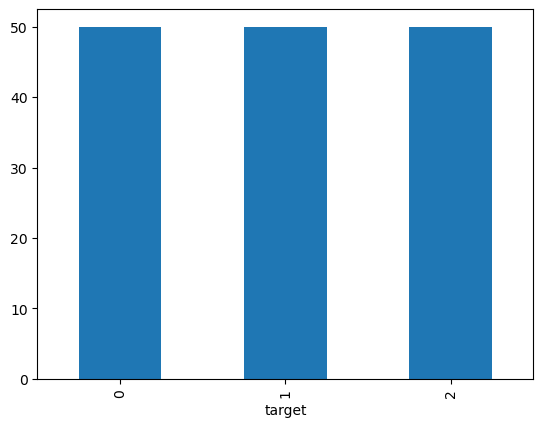

In [105]:
df.value_counts("target", sort=False).plot(kind="bar")

#### Split the data into the predicting values X and the class y
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

In [106]:
X = df.drop("target", axis=1)
y = df["target"]

### Prepare the baseline: holdout method

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=random_state)

print(f"There are {X_train.shape[0]} samples in the training dataset")
print(f"There are {X_test.shape[0]} samples in the test dataset")
print(f"Each sample has {X_train.shape[1]} features")

There are 49 samples in the training dataset
There are 101 samples in the test dataset
Each sample has 4 features


- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(criterion="entropy")`
- Fit the estimator on the train data and target

In [108]:
model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [109]:
y_train_predict = model.predict(X_train)
accuracy_train = accuracy_score(y_train_predict, y_train) * 100
print(f"Accuracy on training set: {accuracy_train:.2f}%")

Accuracy on training set: 100.00%


Let's see how it works on test data, and, comparing with the result on training data, see if you can suspect *overfitting*
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [110]:
y_test_predict = model.predict(X_test)
accuracy_test = accuracy_score(y_test_predict, y_test) * 100
print(f"Accuracy on test set: {accuracy_test:.2f}%")

fitted_max_depth = model.tree_.max_depth
print(f"The maximum depth of the tree is: {fitted_max_depth}")

parameter_values = range(1, fitted_max_depth + 1)

Accuracy on test set: 92.08%
The maximum depth of the tree is: 2


Prepare the decision tree parameters and the scores 

In [113]:
# Set the parameters by cross-validation
tuned_param_dt = [{'max_depth': [*range(1,fitted_max_depth+1)]
                , 'criterion' : ['entropy', 'gini']}]

scores = ['accuracy'
        , 'precision_macro'
        , 'recall_macro'
        , 'f1_macro']

### Loop on scores
- iterate varying the score function
    - fit the estimator using the training data and Cross Validation with `GridSearchCV(estimator, parameters, cv_folds)`
        - the resulting model will be the best one according to the current score function
    - print the best estimator
    - print the best parameter set and the results for each set of parameters using the above defined function
    - predict the target for the test set using the `.predict` method
    - print the classification report
    - display the confusion matrix with `ConfusionMatrixDisplay`

Tuning hyper-parameters for accuracy
DecisionTreeClassifier(criterion='entropy', max_depth=2)
Best score: 0.979
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       0.90      0.84      0.87        32
           2       0.85      0.90      0.88        31

    accuracy                           0.92       101
   macro avg       0.92      0.92      0.92       101
weighted avg       0.92      0.92      0.92       101

Tuning hyper-parameters for precision_macro
DecisionTreeClassifier(criterion='entropy', max_depth=2)
Best score: 0.984
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       0.90      0.84      0.87        32
           2       0.85      0.90      0.88        31

    accuracy                           0.92       101
   macro avg       0.92      0.92      0.92       101
weighted avg       0.92      0.92      0.92       101

Tuning 

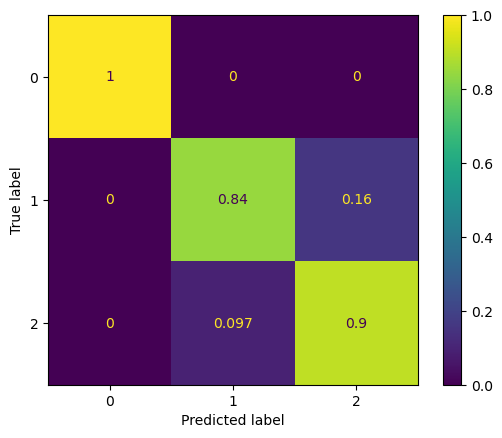

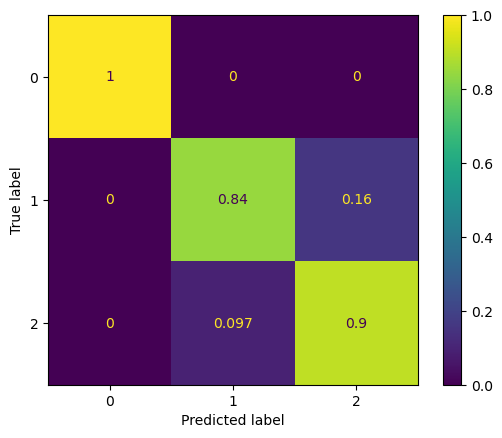

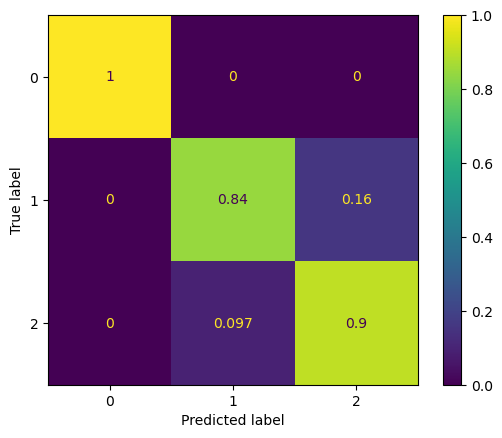

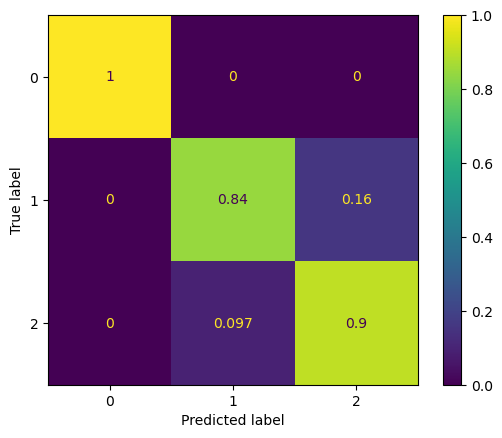

In [114]:
for score in scores:
    print(f"Tuning hyper-parameters for {score}")

    gs = GridSearchCV(estimator=model, param_grid=tuned_param_dt, cv=n_splits, scoring=score)
    gs.fit(X_train, y_train)

    print(gs.best_estimator_)

    best_score = gs.best_score_
    print(f"Best score: {best_score:.3f}")

    y_p = gs.best_estimator_.predict(X_test)
    print(classification_report(y_test, y_p))

    cm = confusion_matrix(y_test, y_p, labels=gs.best_estimator_.classes_, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=gs.classes_)
    disp.plot()
